# **Projeto - Paralelismo GPU**


 ### **Introdução & Análise**

Nesta etapa do projeto temos como objetivo explorar os mecanismos de paralelismo multicore utilizando GPU. Para tanto, utilizaremos a implementação da busca exaustiva explorada anteriormente no curso, uma vez que esta tem o desempenho significativamente comprometido quando trabalhamos com sequências muito grandes de DNA.
Na busca exaustiva, o calculo de score é feito através de um procedimento básico realizado para cada par de subsequencias analisadas, e é ele que iremos paralelisar, como mostra o código abaixo:

In [ ]:
%%writefile main.cu
#include <iostream>
#include<random>
#include <algorithm>
#include <thrust/transform.h>
#include <thrust/reduce.h>
#include <thrust/device_vector.h>


using namespace std;

struct custom_transform
{
    __host__ __device__

    double operator()(const char& a, const char& b)
    { 
        if (a == b)
        {
            return 2;

        }

        return -1;
    }
};





int main()
{

    int n, m;    
    string SeqA, SeqB;

    cout << "Size Sequence A" << endl;
    cin >> n;
    cout << "Size Sequence B" << endl;
    cin >> m;
    cout << "Sequence A" << endl;
    cin >> SeqA;
    cout << "Sequence B" << endl;
    cin >> SeqB;

    vector<string> all_SeqA;
    vector<string> all_SeqB;

    int max;

    if(n>m){
        max = m;
    }else{
        max = n;
    }

    


    int  Asize, Bsize;
     
    
    int match = 0;
   



    // Removing duplicated SeqA
    std::sort(all_SeqA.begin(), all_SeqA.end());
    all_SeqA.erase(std::unique(all_SeqA.begin(), all_SeqA.end()), all_SeqA.end());

    // Removing duplicated SeqB
    std::sort(all_SeqB.begin(), all_SeqB.end());
    all_SeqB.erase(std::unique(all_SeqB.begin(), all_SeqB.end()), all_SeqB.end());

    thrust::device_vector<char> SeqA_GPU(n);
    thrust::device_vector<char> SeqB_GPU(m);
    thrust::device_vector<int> MatchVec(max);


for(int r=0; r<n; r++){
	SeqA_GPU[r] = SeqA[r];		
}
	for(int y=0; y<m;y++){
	SeqB_GPU[y] = SeqB[y];
}

    for(int i = 0; i < n; i++){
        for(int j = i + 1; j < n; j++){

            Asize = j - i;

            for (int i_B = 0; i_B < m; i_B++) {

                for (int j_B = i_B + 1; j_B < m; j_B++){


                    Bsize = j_B - i_B;

                    if (Asize == Bsize) {	
			
                        thrust::transform(SeqA_GPU.begin() + i, SeqA_GPU.begin() + j, SeqB_GPU.begin() + i_B, MatchVec.begin(), custom_transform());

                        int score = thrust::reduce(MatchVec.begin(), MatchVec.begin() +Bsize ,0, thrust::plus<int>());
                        
                        if (score > match) {
                            match = score;
                        }
                    }
                }
            }   
        }
    }
    

    

    cout << "Resultados Finais:"<< endl;
    cout << "Match Max:"<< endl;
    cout << match << endl;


    cout << ""<< endl;
    cout << "EOF"<< endl;    

    return 0;
}

Overwriting main.cu


Para criar as operações, foi implementado um struct "custom_transform", com a marcação "__device__" para indiciar compilação pela GPU, onde o operator recebe as substrings e retorna o resultado da comparação dos caracteres.
Em seguida, foi utilizado o "device_vector" da biblioteca "Thrust" para criar os vetores de "char" *SeqA_GPU* e *SeqB_GPU* na GPU que armazenariam as sequencias indicadas para comparação, além do vetor *MatchVec* resultante da comparação dessas strings que armazenaria o score.
Com isso, foi realizado o paralelismo através do "transform" do "Thrust", que recebe os indices dos caracteres que formam a substring a ser analisada e aplica o "custom_transform" e, por fim, foi utilizado o "reduce" para calcular o score máximo entre todas as substrings comparadas.

In [ ]:
!nvcc -arch=sm_37 -std=c++14 main.cu -o main

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [15]:
import random
max = 300
def Seq_Gen(n):
    file = 'entries/dna.seq' + str(n)
    f = open(file, 'w')
    seq=[str(n)+'\n',
     str(n)+'\n',
     ''.join(random.choices(['A','T','C','G','-'],k=n))+'\n',
     ''.join(random.choices(['A','T','C','G','-'],k=n))]
    f.writelines(seq)
    f.close()

i = 10
while i <max:
  Seq_Gen(i)
  i+=10

In [16]:
# Criando uma lista com entradas ordenadas e seus respectivos tamanhos

import subprocess
import time
import os
import matplotlib.pyplot as plt 
directory = 'entries'
entries = []
size_entries = []
i = 10

while i < max:

  for filename in os.listdir(directory):

    if filename == "dna.seq" + str(i):
      f = os.path.join(directory, filename)
      # checking if it is a file
      if os.path.isfile(f):
        entries.append(f)
  i+=10

i = 10     
while i < max:
  size_entries.append(i)
  i+=10

In [17]:
# Funções para multiplas execuções (em for)

def roda_com_entrada(executavel, arquivo_in):
    with open(arquivo_in) as f:
        start = time.perf_counter()
        proc = subprocess.run(['./' + executavel], input=f.read(), text=True, capture_output=True)
        #print(arquivo_in)
        end = time.perf_counter()        
        time1 = end - start  
        #print(time1)     
    
    return (time1)

def multiplas_rodagens(executavel, lista_entradas):
    tempos = []
    for i in lista_entradas:
        tempo = roda_com_entrada(executavel,i)
        tempos.append(tempo)
    return tempos

In [18]:

tempos_serial = []
tempos_paralelo = []

tempos_paralelo = multiplas_rodagens("main", entries)

In [19]:
print(len(tempos_paralelo))

29


In [20]:
%%writefile bruteforce.cpp
#include <iostream>
#include<random>
#include <algorithm>

using namespace std;

int calcula_valor(char a, char b){
    if(a==b){
        return 2;
    }else{
        return -1;
    }
}



// https://stackoverflow.com/questions/15726641/find-all-possible-substring-in-fastest-way
vector<string> subs_generator(string DNA, int size){
    vector<string> lista_subs;
    
    for(int i = 0; i < size; i++){
        for(int j = i + 1; j < size; j++){

            string x = DNA.substr(i,j);           
            lista_subs.push_back(x);
            
        }
        
        lista_subs.push_back(DNA);
        
    }
    return lista_subs;
}

int calculadora(string seqA, string seqB){
  int valor = 0;
  int contador = seqA.size();
  for (int i = 0; i < contador; i++){
    valor += calcula_valor(seqA[i], seqB[i]);
  }
  return valor;
}

int main()
{

    int n, m;    
    string SeqA, SeqB;

    cout << "Size Sequence A" << endl;
    cin >> n;
    cout << "Size Sequence B" << endl;
    cin >> m;
    cout << "Sequence A" << endl;
    cin >> SeqA;
    cout << "Sequence B" << endl;
    cin >> SeqB;

    vector<string> all_SeqA;
    vector<string> all_SeqB;

    int max;

    if(n>m){
        max = m;
    }else{
        max = n;
    }

    all_SeqA = subs_generator(SeqA, n);
    all_SeqB = subs_generator(SeqB, m);


    int cand_SeqA, cand_SeqB, match, id, contador, candidato;
    string finalSeqA, finalSeqB; 
    contador = 0;
    cand_SeqA = 0;
    cand_SeqB = 0;
   



    // Removing duplicated SeqA
    std::sort(all_SeqA.begin(), all_SeqA.end());
    all_SeqA.erase(std::unique(all_SeqA.begin(), all_SeqA.end()), all_SeqA.end());

    // Removing duplicated SeqB
    std::sort(all_SeqB.begin(), all_SeqB.end());
    all_SeqB.erase(std::unique(all_SeqB.begin(), all_SeqB.end()), all_SeqB.end());


    for (string i: all_SeqA){
        for (string j: all_SeqB){

            if(i.size() == j.size()){
                candidato = calculadora(i,j);
                if(contador == 0){
                    match = candidato;
                    finalSeqA = i;
                    finalSeqB = j;

                }else if(candidato>match){
                    match = candidato;
                    finalSeqA = i;
                    finalSeqB = j;

                }
            }
            contador ++;
                
            }
        
        
    }
    

    

    cout << "Resultados Finais:"<< endl;
    cout << "Match Max:"<< endl;
    cout << match << endl;
    cout << "Substrings que maximizaram o match:"<< endl;
    cout << "Seq A:"<< endl;
    cout << finalSeqA << endl;
    cout << "Seq B:"<< endl;
    cout << finalSeqB << endl;

    cout << ""<< endl;
    cout << "EOF"<< endl;    

    return 0;
}

Writing bruteforce.cpp


In [21]:
!g++ -O3 bruteforce.cpp -o serial

In [24]:
tempos_serial = multiplas_rodagens("serial", entries)

In [25]:
len(tempos_serial)

29

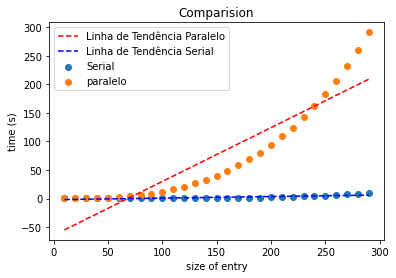

In [27]:
plt.scatter(size_entries, tempos_serial,  label = "Serial")
plt.scatter(size_entries, tempos_paralelo, label = "paralelo")

import numpy as np

z = np.polyfit(size_entries, tempos_paralelo, 1)
p = np.poly1d(z)
plt.plot(size_entries,p(size_entries),"r--", label = "Linha de Tendência Paralelo")

z = np.polyfit(size_entries, tempos_serial, 1)
p = np.poly1d(z)
plt.plot(size_entries,p(size_entries),"b--", label = "Linha de Tendência Serial")

plt.ylabel('time (s)')
plt.xlabel('size of entry')
 

plt.legend()
plt.title('Comparision')
plt.show()